#### Task 1

In [3]:
import numpy as np
import torch

Generating the dataset

In [4]:
np.random.seed(45)
num_samples = 40
   
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [5]:
# Reshape and convert to tensors
x = torch.from_numpy(x1.reshape(-1, 1))
y = torch.from_numpy(y.reshape(-1, 1))

In [6]:
theta0 = torch.zeros(1,requires_grad=True)
theta1 = torch.zeros(1,requires_grad=True)

In [7]:
def lossfn(theta0, theta1, x, y):
    y_pred = theta0 + theta1*x
    return torch.mean((y_pred - y)**2)

In [8]:
loss = lossfn(theta0, theta1, x, y)
loss.backward()
print(theta0.grad.item())
print(theta1.grad.item())

-7.447053909301758
-1.0253016948699951


In [9]:
grads = []
theta0 = torch.zeros(1,requires_grad=True)
theta1 = torch.zeros(1,requires_grad=True)
for i in range(num_samples):
    loss = lossfn(theta0, theta1, x, y)
    loss.backward()
    grads.append([theta0.grad.item(), theta1.grad.item()])
    theta0.grad.zero_()
    theta1.grad.zero_()
    

In [10]:
grad0 = [g[0] for g in grads]
grad1 = [g[1] for g in grads]
print(np.mean(grad0))
print(np.mean(grad1))

-7.447053909301758
-1.0253016948699951


In [11]:
def gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 100, min_loss = 0.00):
    epsilon = 0.001
    # Initialize the weights
    theta0 = torch.zeros(1,requires_grad=True)
    theta1 = torch.zeros(1,requires_grad=True)
    trajectory = []
    for i in range(epochs):
        for j in range(num_samples//batch_size):
            lower = j*batch_size
            upper = min((j+1)*batch_size, num_samples)
            X_batch, y_batch = x[lower:upper], y[lower:upper]
            loss = lossfn(theta0, theta1, X_batch, y_batch)
            loss.backward()
            # Update the weights (stop tracking the gradients)
            with torch.no_grad():
                theta0 -= lr * theta0.grad
                theta1 -= lr * theta1.grad
            # Zero the gradients    
            theta0.grad.zero_()
            theta1.grad.zero_()
        current_loss = lossfn(theta0, theta1, x, y).item()
        trajectory.append({'epoch':i+1, 
                        'theta0': theta0.item(),
                        'theta1': theta1.item(),
                        'loss': current_loss
                    })
        if current_loss <= min_loss + epsilon:
                break
    return trajectory
                
        
        

 Find optimal loss via normal eqn

In [12]:
X = torch.cat([torch.ones_like(x), x], dim=1)
theta_optimal = torch.inverse(X.t() @ X) @ X.t() @ y
y_pred_optimal = X @ theta_optimal
min_loss = torch.mean((y - y_pred_optimal) ** 2).item()

print(f"Optimal parameters: θ0 = {theta_optimal[0].item():.4f}, θ1 = {theta_optimal[1].item():.4f}")
print(f"Minimum loss: {min_loss:.6f}")


Optimal parameters: θ0 = 3.9507, θ1 = 2.6825
Minimum loss: 0.595754


In [13]:
gd = gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 700, min_loss = min_loss)
sgd = gradient_descent(lr = 0.01, batch_size = 1, epochs = 700, min_loss = min_loss)
bgd = gradient_descent(lr = 0.01, batch_size = num_samples//4, epochs = 700, min_loss = min_loss)

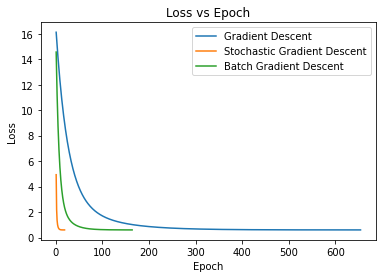

In [14]:
import matplotlib.pyplot as plt

# Extract the loss values for each method
gd_loss = [item['loss'] for item in gd]
sgd_loss = [item['loss'] for item in sgd]
bgd_loss = [item['loss'] for item in bgd]

# Plot the loss versus epoch
plt.plot(range(1,gd[-1]['epoch']+1), gd_loss, label='Gradient Descent')
plt.plot(range(1,sgd[-1]['epoch']+1), sgd_loss, label='Stochastic Gradient Descent')
plt.plot(range(1,bgd[-1]['epoch']+1), bgd_loss, label='Batch Gradient Descent')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Add legend
plt.legend()

# Show the plot
plt.show()

 $\epsilon$ neighbourhood of optimal loss is [$loss_{opt}$, $loss_{opt}$ + $\epsilon$] = [0.5957, 0.5967]

In [111]:
gdepochs = []
sgdepochs = []
bgdepochs = []
for i in range(10):
    gdepochs.append(gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 700, min_loss = min_loss)[-1]['epoch'])
    sgdepochs.append(gradient_descent(lr = 0.01, batch_size = 1, epochs = 700, min_loss = min_loss)[-1]['epoch'])
    bgdepochs.append(gradient_descent(lr = 0.01, batch_size = num_samples//4, epochs = 700, min_loss = min_loss)[-1]['epoch'])
print(f"Average epochs for Gradient Descent convergence: {np.mean(gdepochs)}")
print(f"Average iterations for Gradient Descent convergence: {np.mean(gdepochs)}")
print(f"Loss after convergence: {gdepochs[-1]}")
print(f"Average epochs for Stochastic Gradient Descent convergence: {np.mean(sgdepochs)}")
print(f"Average iterations for Stochastic Gradient Descent convergence: {(np.mean(sgdepochs)*num_samples)}")
print(f"Average epochs for Batch Gradient Descent convergence: {np.mean(bgdepochs)}")
print(f"Average iterations for Batch Gradient Descent convergence: {(np.mean(bgdepochs)*num_samples//4)}")

Average epochs for Gradient Descent convergence: 654.0
Average iterations for Gradient Descent convergence: 654.0
Average epochs for Stochastic Gradient Descent convergence: 19.0
Average iterations for Stochastic Gradient Descent convergence: 760.0
Average epochs for Batch Gradient Descent convergence: 164.0
Average iterations for Batch Gradient Descent convergence: 1640.0


Full batch gradient descent takes the most number of epochs (654) to converge sufficiently close as compared to stochastic gradient descent (19) and mini-batch gradient descent (164). This is because gradient descent takes a granular approach by calculating gradients on entire dataset and then applying updates to the weights every epoch. However BGD and SGD calculate gradients on a smaller subset (one example for SGD) and apply multiple weight updates every epoch helping them converge quicker.  

In [112]:
gd = gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 700, min_loss = min_loss)
sgd = gradient_descent(lr = 0.01, batch_size = 1, epochs = 700, min_loss = min_loss)
bgd = gradient_descent(lr = 0.01, batch_size = num_samples//4, epochs = 700, min_loss = min_loss)

In [16]:
theta0_range = np.linspace(0, 8, 100)
theta1_range = np.linspace(0, 6, 100)
T0, T1 = np.meshgrid(theta0_range, theta1_range)
# Compute the loss surface
Z = np.zeros_like(T0)
for i in range(T0.shape[0]):
    for j in range(T0.shape[1]):
        Z[i,j] = lossfn(torch.tensor(T0[i,j]), torch.tensor(T1[i,j]), x, y).item()

In [93]:
from matplotlib.animation import FuncAnimation
methods = [('Full-batch GD', gd[:15], 'r'), ('Mini-batch GD', bgd[:15], 'g'), ('SGD', sgd[:15], 'b')]
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white', edgecolor='none')
contour = ax.contour(T0, T1, Z, levels=np.logspace(-2, 3, 20), cmap='viridis')
ax.clabel(contour, inline=True, fontsize=8)
ax.set_xlabel('θ0', fontsize=16)
ax.set_ylabel('θ1', fontsize=16)
lines = [ax.plot([], [], f'{color}o-', label=name, linewidth=1.5, markersize=5)[0] 
         for name, _, color in methods]
ax.legend()
title = ax.set_title('Gradient Descent Methods', fontsize=16)
epoch_disp = ax.text(0.5, 0.95, '', transform=ax.transAxes, fontsize=16, horizontalalignment='center')
gdloss_disp = ax.text(0.3, 0.85, '', transform=ax.transAxes, fontsize=14, horizontalalignment='right')
bgdloss_disp = ax.text(0.5, 0.85, '', transform=ax.transAxes, fontsize=14, horizontalalignment='center')
sgdloss_disp = ax.text(0.7, 0.85, '', transform=ax.transAxes, fontsize=14, horizontalalignment='left')
def animate(i):
    for line, (name, trajectory, _) in zip(lines, methods):
        theta0_values = [trajectory[epoch]['theta0'] for epoch in range(i+1)]
        theta1_values = [trajectory[epoch]['theta1'] for epoch in range(i+1)]
        line.set_data(theta0_values, theta1_values)
    epoch_disp.set_text(f'Epoch: {i+1}')
    gdloss_disp.set_text(f'GD Loss: {gd[i]["loss"]:.4f}')
    bgdloss_disp.set_text(f'Batch Loss: {bgd[i]["loss"]:.4f}')
    sgdloss_disp.set_text(f'SGD Loss: {sgd[i]["loss"]:.4f}')
    return lines + [title]
anim = FuncAnimation(fig, animate, frames=15, interval=100, blit=True)
anim.save('gradient_descent.gif', writer='pillow', fps=2)
plt.close()

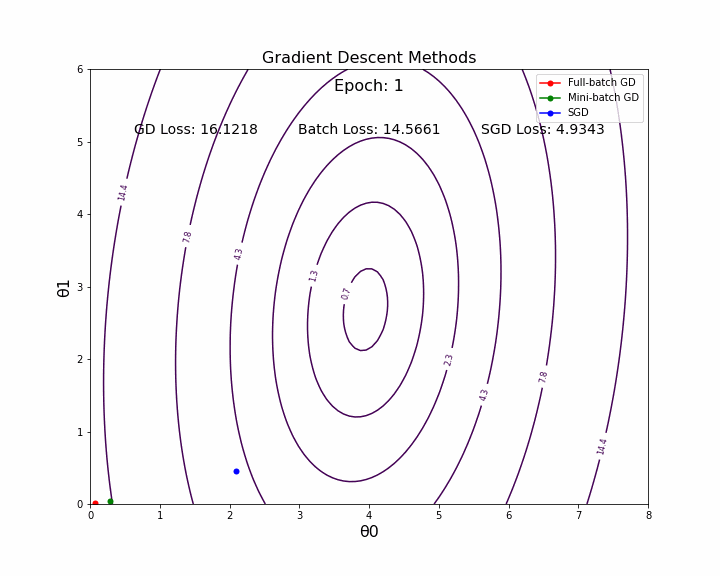

In [94]:
from IPython.display import Image
Image(filename='gradient_descent.gif')

In [19]:
def momentum_gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 100, min_loss = 0.00, gamma = 0.9):
    epsilon = 0.001
    # Initialize the weights
    theta0 = torch.zeros(1,requires_grad=True)
    theta1 = torch.zeros(1,requires_grad=True)
    v0 = 0
    v1 = 0
    trajectory = []
    for i in range(epochs):
        for j in range(num_samples//batch_size):
            lower = j*batch_size
            upper = min((j+1)*batch_size, num_samples)
            X_batch, y_batch = x[lower:upper], y[lower:upper]
            loss = lossfn(theta0, theta1, X_batch, y_batch)
            loss.backward()
            # Update the weights (stop tracking the gradients)
            with torch.no_grad():
                v0 = gamma * v0 + lr * theta0.grad
                v1 = gamma * v1 + lr * theta1.grad
                theta0 -= v0
                theta1 -= v1
            # Zero the gradients    
            theta0.grad.zero_()
            theta1.grad.zero_()
        current_loss = lossfn(theta0, theta1, x, y).item()
        trajectory.append({'epoch':i+1, 
                        'theta0': theta0.item(),
                        'theta1': theta1.item(),
                        'loss': current_loss,
                        'v0': v0.item(),
                        'v1': v1.item() 
                    })
        if current_loss <= min_loss + epsilon:
                break
    return trajectory

In [123]:
mgdepochs = []
msgdepochs = []
gdepochs = []
mgdlosses = []
msgdlosses = []
gdlosses = []
for i in range(10):
    mgd = momentum_gradient_descent(lr = 0.005, batch_size = num_samples, epochs = 700, min_loss = min_loss, gamma = 0.8)[-1]
    msgd = momentum_gradient_descent(lr = 0.005, batch_size = 1, epochs = 700, min_loss = min_loss, gamma = 0.8)[-1]
    gd = gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 700, min_loss = min_loss)[-1]
    mgdepochs.append(mgd['epoch'])
    msgdepochs.append(msgd['epoch'])
    gdepochs.append(gd['epoch'])
    mgdlosses.append(mgd['loss'])
    msgdlosses.append(msgd['loss'])
    gdlosses.append(gd['loss'])    
print(f"Average epochs for Full Batch Momentum Gradient Descent convergence: {np.mean(mgdepochs)}")
print(f"Average iterations for convergence: {np.mean(mgdepochs)}")
print(f"Loss after convergence: {np.mean(mgdlosses)}")
print(f"Average epochs for Stochastic Momentum Gradient Descent convergence: {np.mean(msgdepochs)}")
print(f"Average iterations for convergence: {(np.mean(msgdepochs)*num_samples)}")
print(f"Loss after convergence: {np.mean(msgdlosses)}")
print(f"Average epochs for Vanilla Gradient Descent convergence: {np.mean(gdepochs)}")
print(f"Average iterations for convergence: {np.mean(gdepochs)}")
print(f"Loss after convergence: {np.mean(gdlosses)}")



Average epochs for Full Batch Momentum Gradient Descent convergence: 248.0
Average iterations for convergence: 248.0
Loss after convergence: 0.5967318812272298
Average epochs for Stochastic Momentum Gradient Descent convergence: 6.0
Average iterations for convergence: 240.0
Loss after convergence: 0.59608586081631
Average epochs for Vanilla Gradient Descent convergence: 654.0
Average iterations for convergence: 654.0
Loss after convergence: 0.5967484549094932


In [122]:
mgd = momentum_gradient_descent(lr = 0.005, batch_size = num_samples, epochs = 1000, min_loss = min_loss, gamma = 0.8)
msgd = momentum_gradient_descent(lr = 0.005, batch_size = 1, epochs = 1000, min_loss = min_loss, gamma = 0.8)
gd = gradient_descent(lr = 0.01, batch_size = num_samples, epochs = 1000, min_loss = min_loss)

Text(0, 0.5, 'Loss')

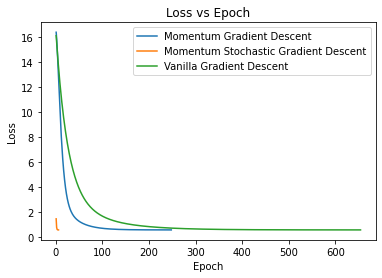

In [117]:
mgd_loss = [item['loss'] for item in mgd]
msgd_loss = [item['loss'] for item in msgd]
gd_loss = [item['loss'] for item in gd]

plt.plot(range(1,mgd[-1]['epoch']+1), mgd_loss, label='Momentum Gradient Descent')
plt.plot(range(1,msgd[-1]['epoch']+1), msgd_loss, label='Momentum Stochastic Gradient Descent')
plt.plot(range(1,gd[-1]['epoch']+1), gd_loss, label='Vanilla Gradient Descent')
plt.title('Loss vs Epoch')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [107]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
contour = ax.contour(T0, T1, Z, levels=np.logspace(-2, 3, 20), cmap='viridis')
ax.clabel(contour, inline=True, fontsize=8)
ax.set_xlabel('θ0', fontsize=16)
ax.set_ylabel('θ1', fontsize=16)
ax.set_title('Momentum Gradient Descent', fontsize=16)
point = ax.plot([], [], 'ro', label='Trajectory', markersize=5)[0]
gradient_vec = ax.quiver([], [], [], [], color='blue', scale=20, width=0.008)  # Gradient vector
momentum_vec = ax.quiver([], [], [], [], color='green', scale=1, width=0.008)  # Momentum vector
ax.legend(['Trajectory', 'Gradient', 'Momentum'])
epoch_disp = ax.text(0.5, 0.95, '', transform=ax.transAxes, fontsize=16, horizontalalignment='center')
loss_disp = ax.text(0.5, 0.90, '', transform=ax.transAxes, fontsize=14, horizontalalignment='center')
line = ax.plot([], [], 'ro-', label='Momentum Gradient Descent', linewidth=1.5, markersize=5)[0]

def update(frame):
    theta0 = mgd[frame]['theta0']
    theta1 = mgd[frame]['theta1']
    t1, t0 = torch.tensor(theta0, requires_grad=True), torch.tensor(theta1, requires_grad=True)
    loss = lossfn(t0, t1, x, y)
    loss.backward()
    grad0 = t0.grad.item()
    grad1 = t1.grad.item()
    v0 = mgd[frame]['v0']
    v1 = mgd[frame]['v1']
    theta0_values = [mgd[epoch]['theta0'] for epoch in range(frame)]
    theta1_values = [mgd[epoch]['theta1'] for epoch in range(frame)]
    line.set_data(theta0_values, theta1_values)
    point.set_data(theta0, theta1)
    gradient_vec.set_offsets([theta0, theta1])
    gradient_vec.set_UVC(-grad0, -grad1)
    momentum_vec.set_offsets([theta0, theta1])
    momentum_vec.set_UVC(-v0, -v1)
    epoch_disp.set_text(f'Epoch: {mgd[frame]["epoch"]}')
    loss_disp.set_text(f'Loss: {mgd[frame]["loss"]:.4f}')
    return point, gradient_vec, momentum_vec

anim = FuncAnimation(fig, update, frames=15, blit=True)
anim.save('momentum_gradient_descent.gif', writer='pillow', fps=2) 
plt.close()

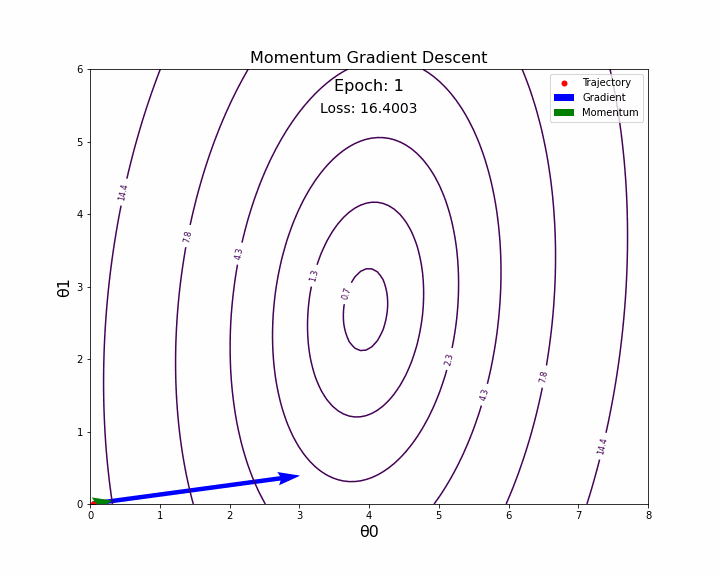

In [108]:
from IPython.display import Image
Image(filename='momentum_gradient_descent.gif')